In [1]:
from __future__ import print_function
import argparse
import easydict
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt

DEBUG = False

# Argument parse and preprocessing

In [2]:
'''
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
'''
args = easydict.EasyDict({
    "batch_size": 128,
    "epochs": 100,
    "no_cuda": False,
    "cuda": True,
    "seed": 1,
    "log_interval": 10
})


torch.manual_seed(args.seed)

#device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda")
#device = torch.cuda.current_device()

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)



# Model

In [3]:
def to_var(x, volatile=False):
    return Variable(x, volatile=volatile)

def encodeIdx2onehot(idx, n):
    batch_size_list = []
    for i, index in enumerate(idx):    
        # one hot
        one_hot_list = [] 
        
        for j in range(n):    
            if j == index:
               one_hot_list.append(torch.ones(28, 28))
            else: 
               one_hot_list.append(torch.zeros(28, 28))
            
        # d:[28, 28, 10]
        one_hot = torch.stack(one_hot_list, 2)
        batch_size_list.append(one_hot)
    
    # d2:[28, 28, 10, 128]
    targets = torch.stack(batch_size_list, 3) 
 
    targets = targets.view(idx.size(0),10,28,28) 
    targets = Variable(targets)
    #targets = targets.cuda()
    
    return targets
    
def decodeIdx2onehot(idx, n):
    
    assert idx.size(1) == 1
    assert torch.max(idx).data[0] < n

    onehot = torch.zeros(idx.size(0), n).cuda()
    idx = idx.cuda()
    onehot.scatter_(1, idx.data, 1)
    onehot = to_var(onehot)
    
    return onehot
    

    # Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    BCE = F.mse_loss(recon_x, x.view(-1, 784), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()        
        self.conv1 = nn.Sequential(
            nn.Conv2d(11, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(784, out_features=400, bias=True),
            nn.ReLU(True),
        )

        self.fc21 = nn.Sequential(
            nn.Linear(400, out_features=20, bias=True)
        )
        
        self.fc22 = nn.Sequential(
            nn.Linear(400, out_features=20, bias=True)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(30, out_features=392, bias=True),
            nn.ReLU(True),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(2, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            #nn.UpsamplingNearest2d(scale_factor=2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(11, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid(),
        )
        
        
    def encode(self, x, c):
        '''
        x: [128, 1, 28, 28]
        c: [128, 1]
        '''
        
        c = encodeIdx2onehot(c, n=10) # c: [128, 10, 28, 28]
        c = c.cuda()
        x = torch.cat((x, c), 1) # x: [128, 11, 28, 28]
        if(DEBUG):
            print("encode:")
            print("c:" + str(c.shape))
            print('x:' + str(x.shape))
        
        h1 = self.conv1(x)
        h1 = h1.view(h1.size(0), -1) # h1: [128, 784]
        
        if(DEBUG):
            print('h1:' + str(h1.shape))
        
        h1 = self.fc1(h1) # h1: [128, 400]
        if(DEBUG):
            print('fc1:' + str(h1.shape))
        
        return self.fc21(h1), self.fc22(h1) # [128, 20], [128, 20]

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar).cuda()
            #eps = torch.randn_like(std)
            eps = torch.FloatTensor(std.size()).normal_().cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z, c):
        '''
        z: [128, 20]
        c: [128, 1]
        '''
        
        c = decodeIdx2onehot(c, 10)
        c = c.cuda()
        if(DEBUG):
            print("decode:")
            print("c:" + str(c.shape))
        
        z = torch.cat([z, c], 1) # z: [128, 30]
        z = z.cuda()
        if(DEBUG):
            print("z.shape:" + str(z.shape))
        
        h3 = self.fc3(z) # h3: [128, 392]
        if(DEBUG):
            print("h3.shape:" + str(h3.shape))
        
        h3 = h3.view(h3.size(0), 2, 14, 14) # h3: [128, 2, 14, 14]
        h3 = self.conv2(h3) # h3: [128, 1, 28, 28]
        if(DEBUG):
            print("h3.shape:" + str(h3.shape))            
            
        return h3

    def forward(self, x, c):
        # x: data
        # c: label
        
        x = x.cuda()
        c = c.cuda()
        mu, logvar = self.encode(x, c)
        
        if(DEBUG):
            print("mu.shape:" + str(mu.shape))
            print("logvar.shape:" + str(logvar.shape))
        #print(mu)
        z = self.reparameterize(mu, logvar)
        z = z.cuda()
        
        if(DEBUG):
            print("z.shape:" + str(z.shape))
        #return self.decode(z), mu, logvar
        z = self.decode(z, c)
        return z.view(z.size(0), -1), mu, logvar




model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



# Training and Testing

In [4]:
def train(epoch, train_loss_list):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        #data = data.to(device)
        #print(data.shape)
        data = Variable(data)
        data = data.cuda()
        
        optimizer.zero_grad()
        label = label.view(-1, 1)
        recon_batch, mu, logvar = model(data, label)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            train_loss_list.append((loss.data[0] / len(data)))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), '\r', end="")

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return train_loss_list


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            #data = data.to(device)
            data = Variable(data)
            data = data.cuda()
            label = label.view(-1, 1)
            recon_batch, mu, logvar = model(data, label)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('')
    print('====> Test set loss: {:.4f}'.format(test_loss), '\r', end="")

# Run

/home/dl2018/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/dl2018/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


====> Epoch: 1 Average loss: 61.5402oss: 42.717915 
====> Epoch: 1 Average loss: 41.7459oss: 37.248253 

====> Epoch: 2 Average loss: 36.2111oss: 34.281311 
====> Epoch: 2 Average loss: 33.3971oss: 35.263718 

====> Epoch: 3 Average loss: 32.0256oss: 31.318932 
====> Epoch: 3 Average loss: 31.0933oss: 30.749973 

====> Epoch: 4 Average loss: 30.5495oss: 31.119143 
====> Epoch: 4 Average loss: 30.1268oss: 27.707237 

====> Epoch: 5 Average loss: 29.7778oss: 31.350906 
====> Epoch: 5 Average loss: 29.5051oss: 29.192616 

====> Epoch: 6 Average loss: 29.3362oss: 27.737495 
====> Epoch: 6 Average loss: 29.1405oss: 30.593437 

====> Epoch: 7 Average loss: 29.0550oss: 29.056431 
====> Epoch: 7 Average loss: 28.9157oss: 28.971100 

====> Epoch: 8 Average loss: 28.8259oss: 28.238590 
====> Epoch: 8 Average loss: 28.7347oss: 28.597574 

====> Epoch: 9 Average loss: 28.6601oss: 28.642511 
====> Epoch: 9 Average loss: 28.5857oss: 28.391327 

====> Epoch: 10 Average loss: 28.5018oss: 27.877537 
==

/home/dl2018/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


====> Epoch: 21 Average loss: 27.7806oss: 27.375191 

====> Epoch: 22 Average loss: 27.7708oss: 28.648001 
====> Epoch: 22 Average loss: 27.7587oss: 27.426178 

====> Epoch: 23 Average loss: 27.7521oss: 28.984119 
====> Epoch: 23 Average loss: 27.7549oss: 27.025763 

====> Epoch: 24 Average loss: 27.7066oss: 27.816795 
====> Epoch: 24 Average loss: 27.6955oss: 27.325802 

====> Epoch: 25 Average loss: 27.6726oss: 28.512938 
====> Epoch: 25 Average loss: 27.6724oss: 26.687664 

====> Epoch: 26 Average loss: 27.6395oss: 28.082922 
====> Epoch: 26 Average loss: 27.6318oss: 27.713364 

====> Epoch: 27 Average loss: 27.6034oss: 26.618565 
====> Epoch: 27 Average loss: 27.6081oss: 27.519588 

====> Epoch: 28 Average loss: 27.5990oss: 27.727577 
====> Epoch: 28 Average loss: 27.5828oss: 27.852982 

====> Epoch: 29 Average loss: 27.5730oss: 27.239307 
====> Epoch: 29 Average loss: 27.5314oss: 26.858658 

====> Epoch: 30 Average loss: 27.5318oss: 27.064869 
====> Epoch: 30 Average loss: 27.5339

====> Epoch: 98 Average loss: 26.9736oss: 27.572388 
====> Epoch: 98 Average loss: 26.9918oss: 26.678581 

====> Epoch: 99 Average loss: 26.9796oss: 25.787516 
====> Epoch: 99 Average loss: 26.9784oss: 25.654198 

====> Epoch: 100 Average loss: 26.9658oss: 27.909344 
====> Epoch: 100 Average loss: 26.9873oss: 26.157797 



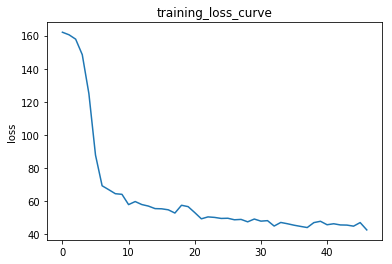

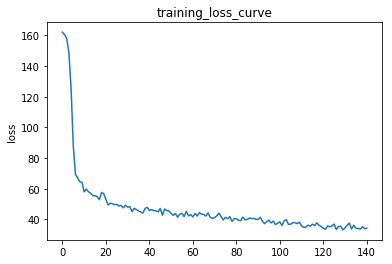

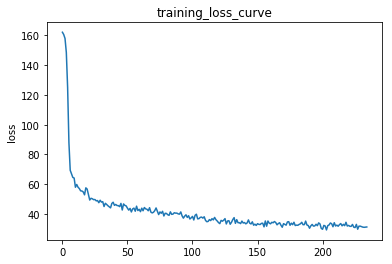

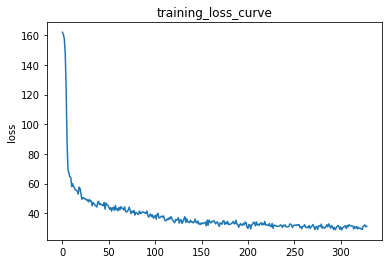

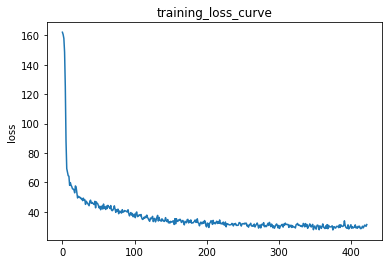

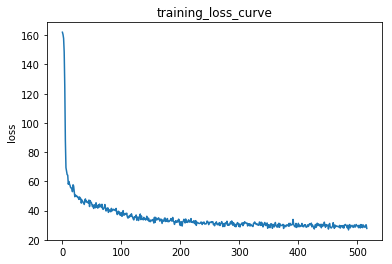

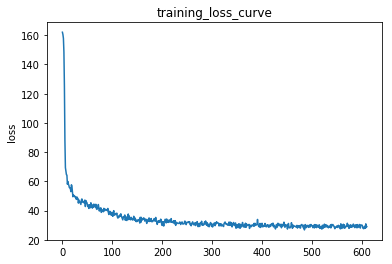

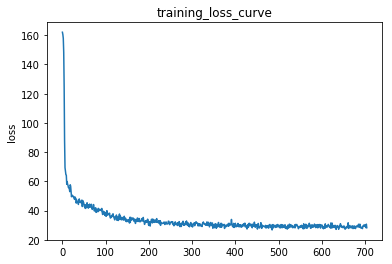

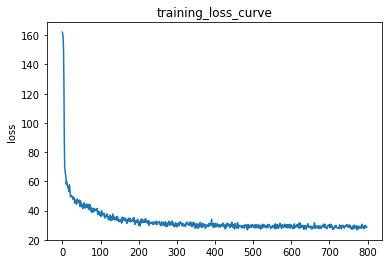

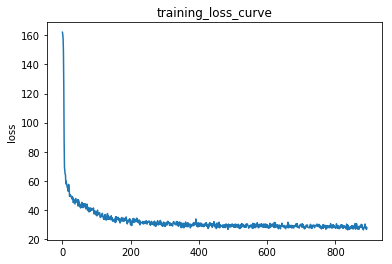

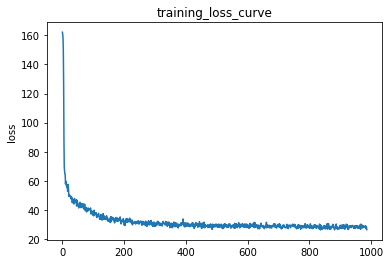

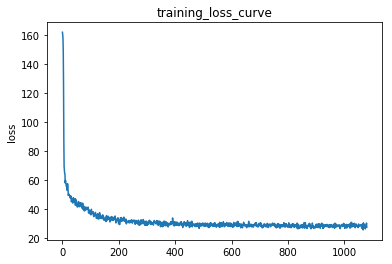

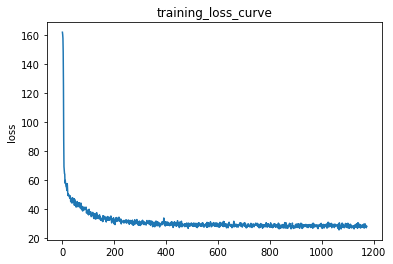

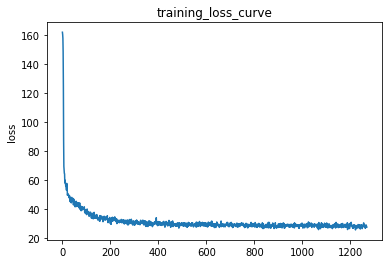

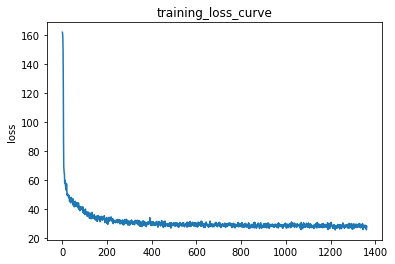

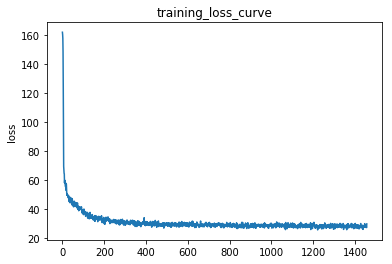

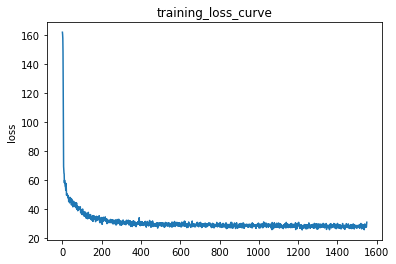

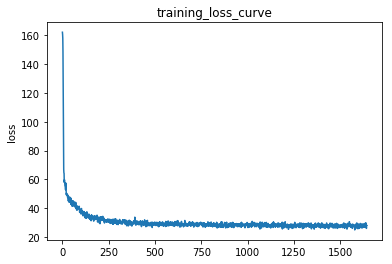

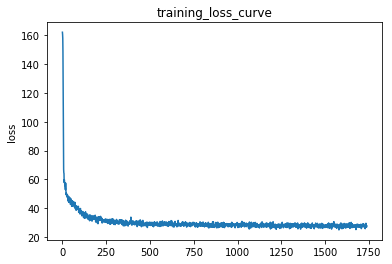

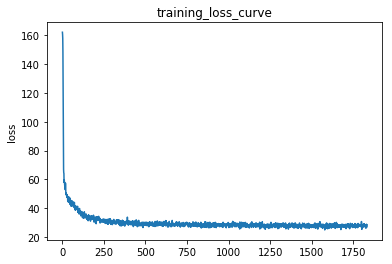

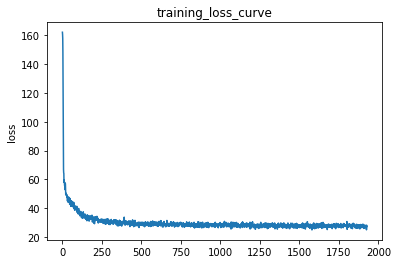

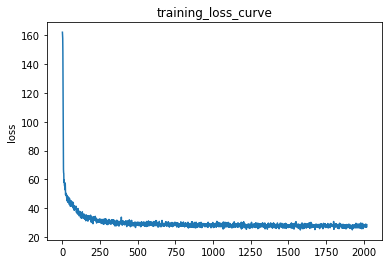

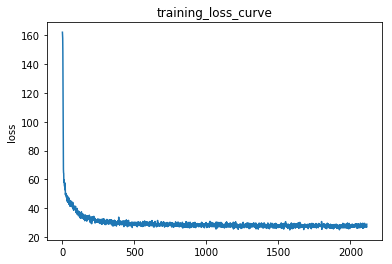

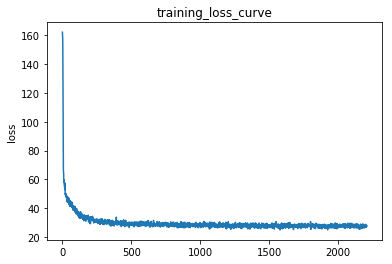

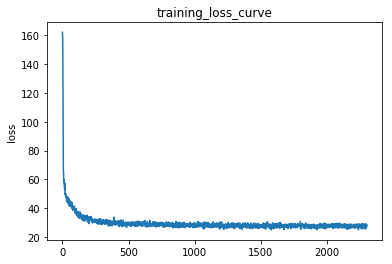

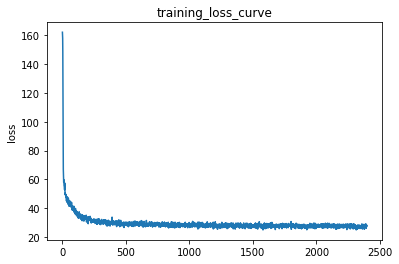

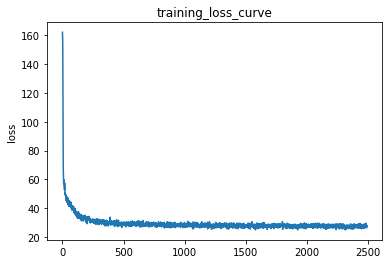

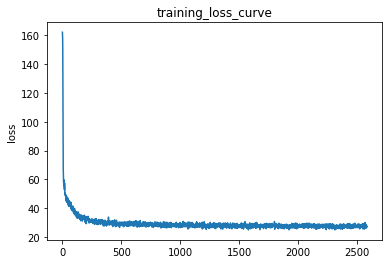

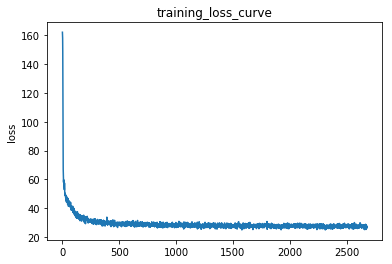

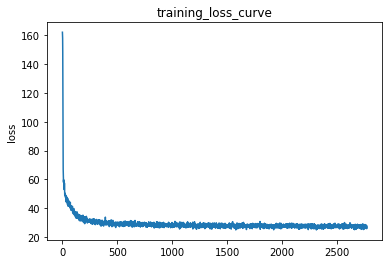

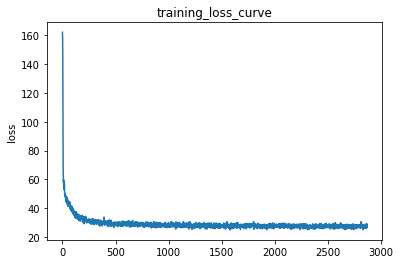

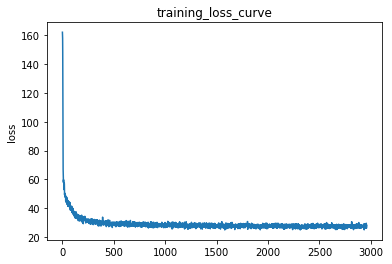

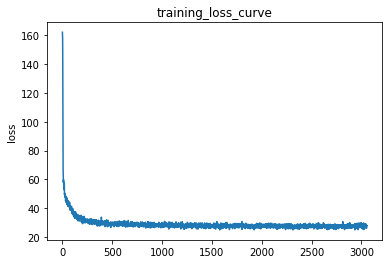

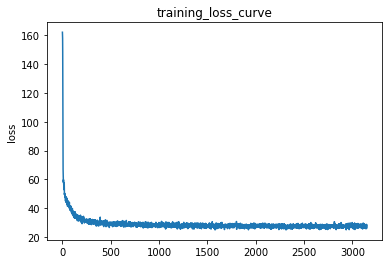

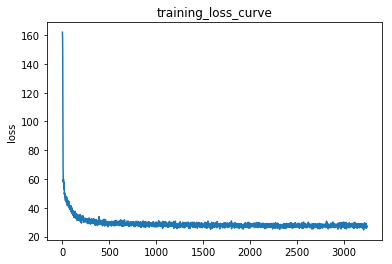

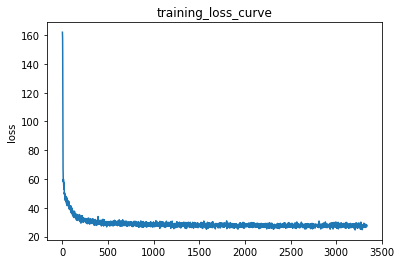

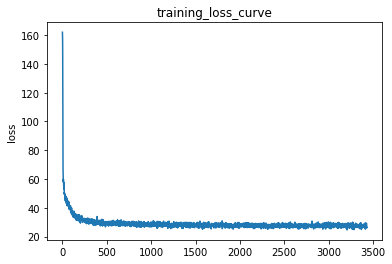

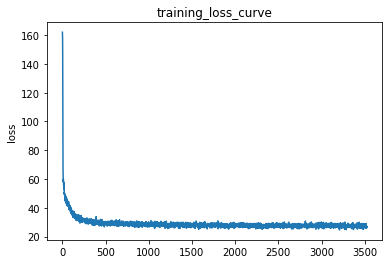

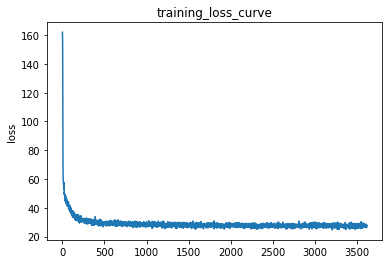

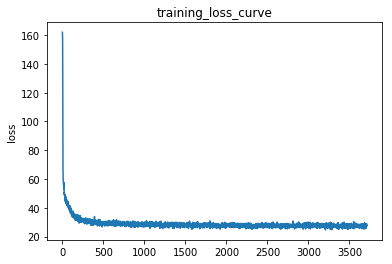

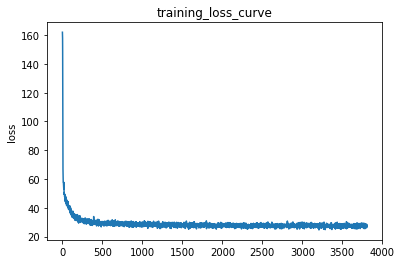

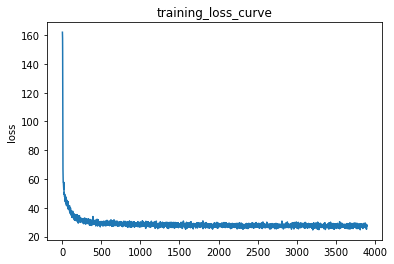

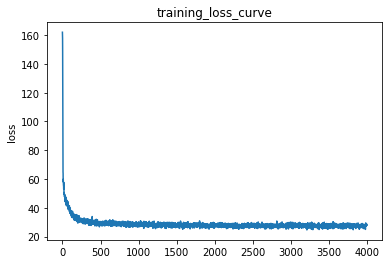

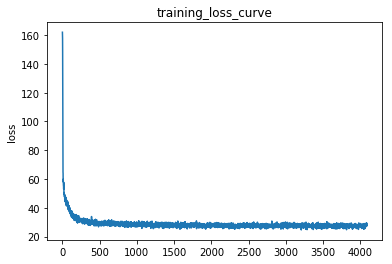

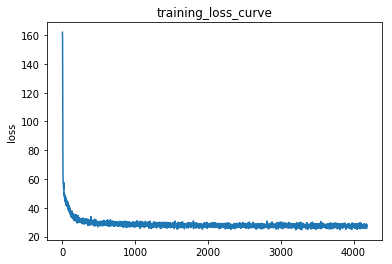

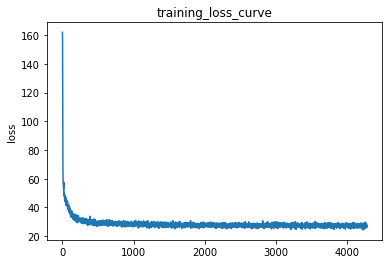

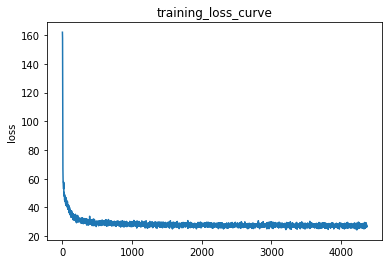

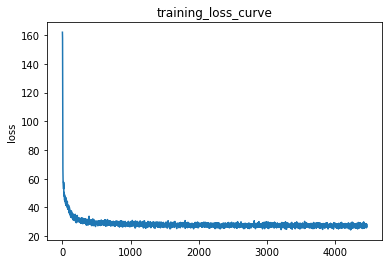

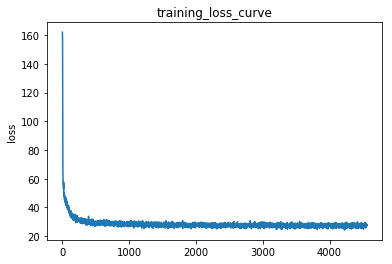

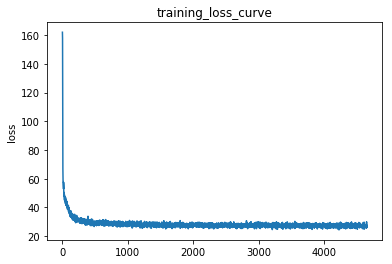

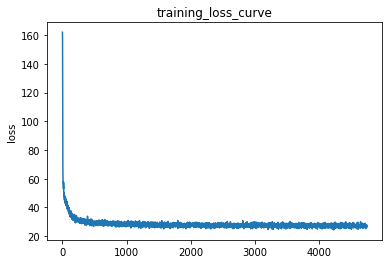

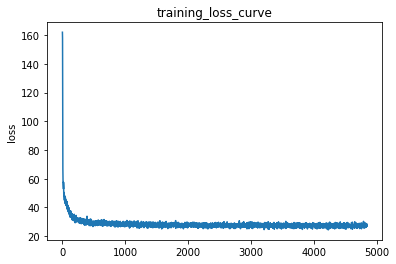

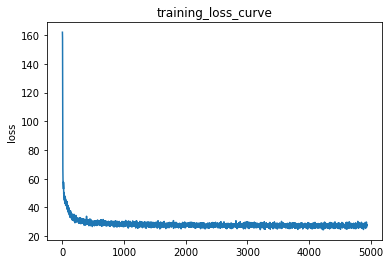

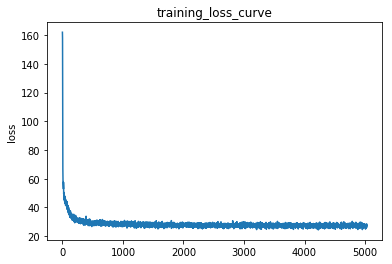

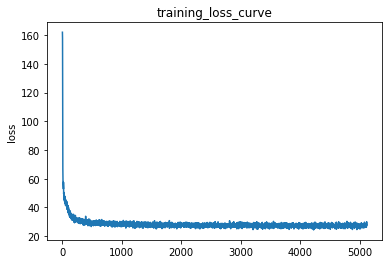

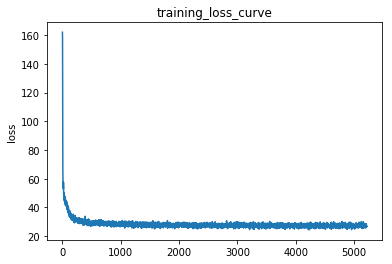

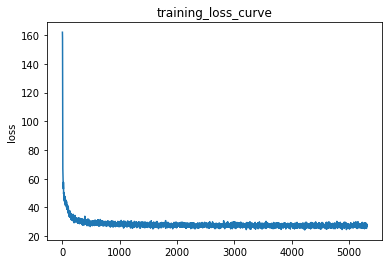

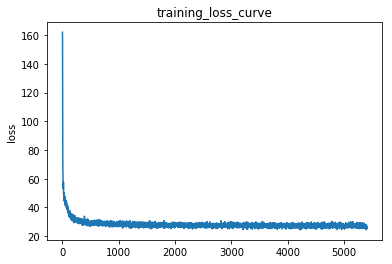

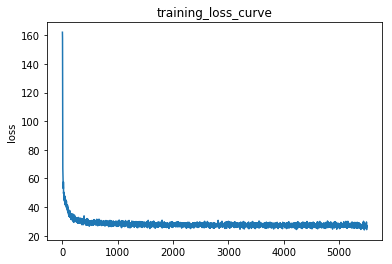

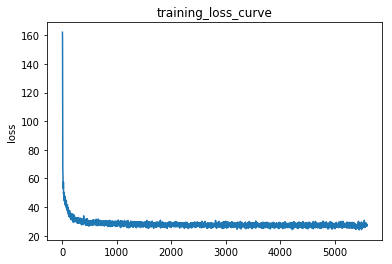

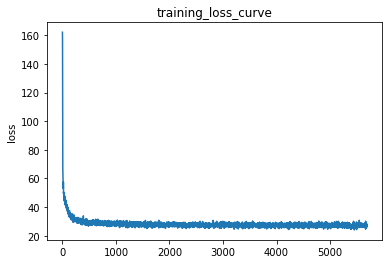

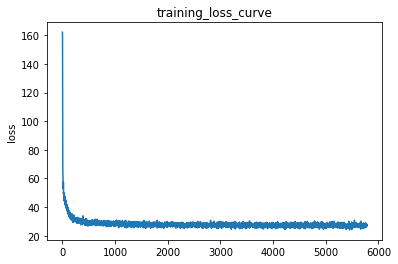

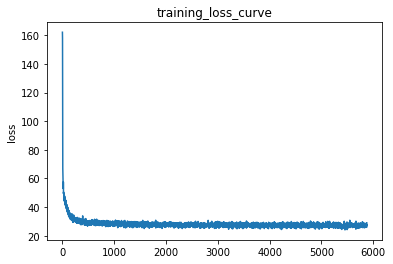

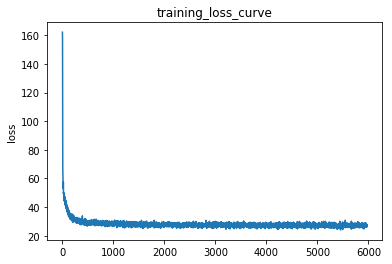

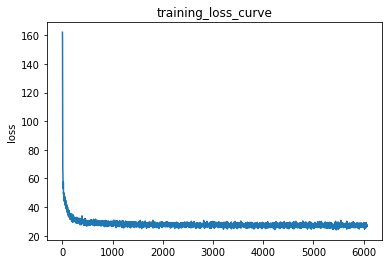

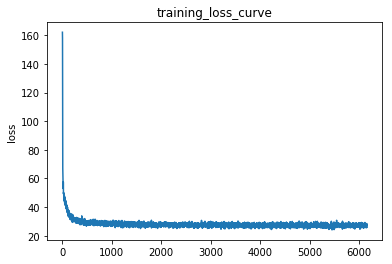

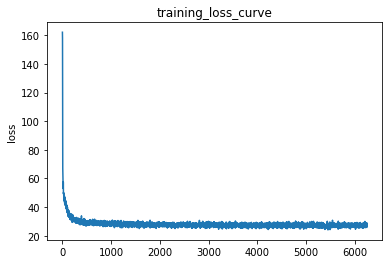

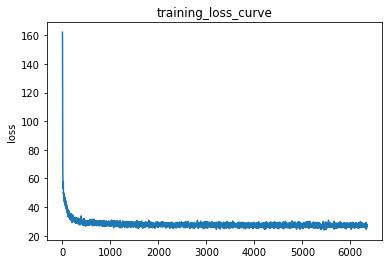

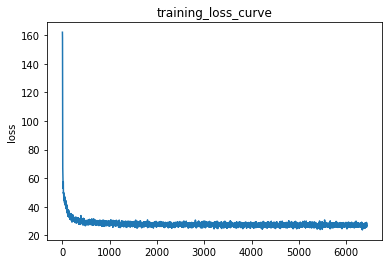

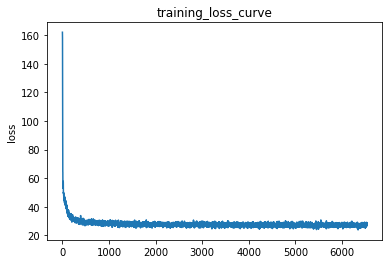

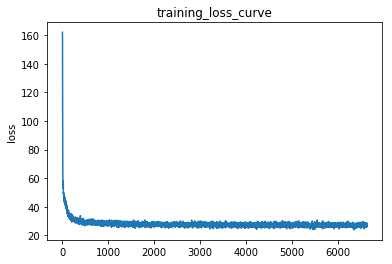

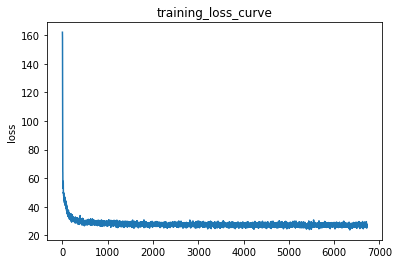

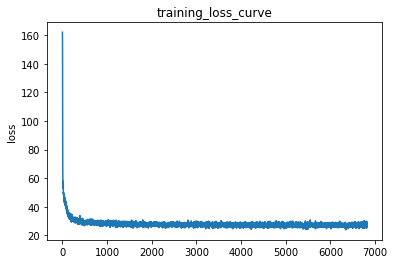

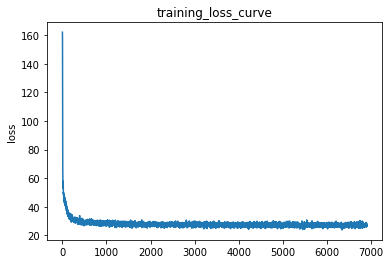

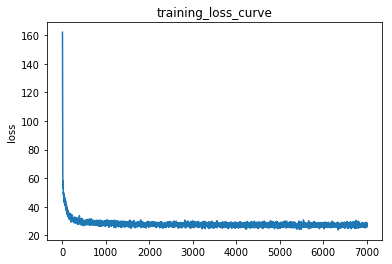

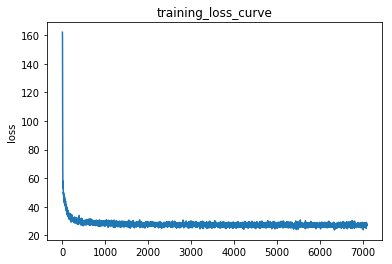

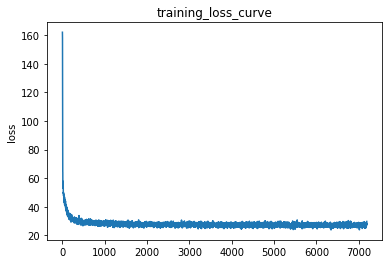

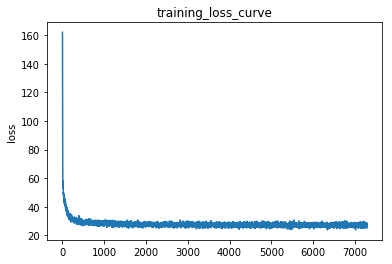

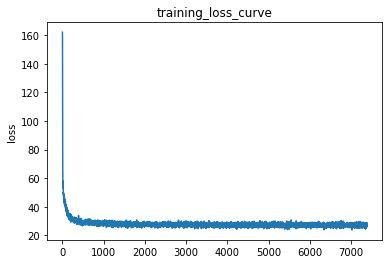

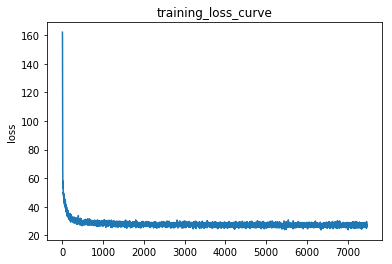

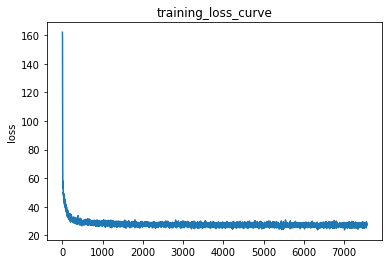

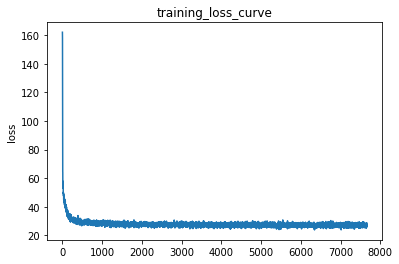

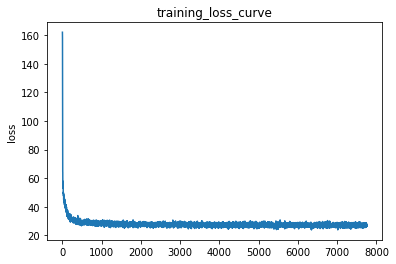

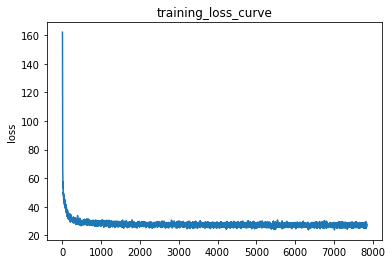

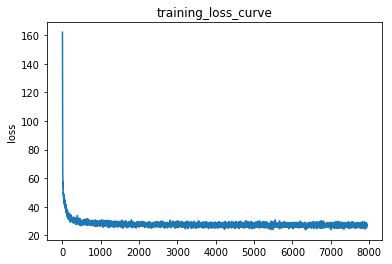

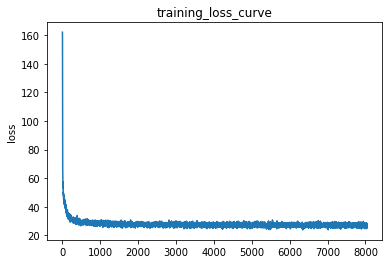

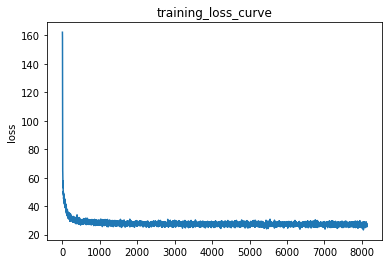

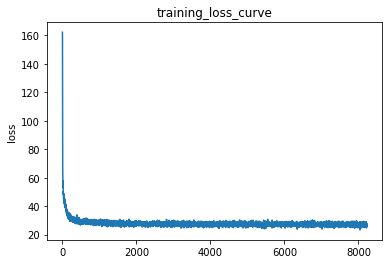

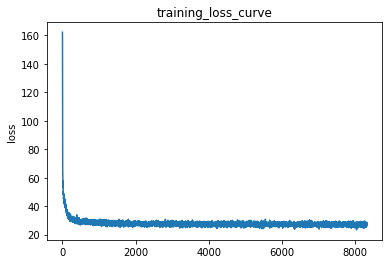

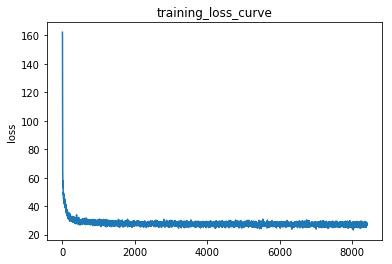

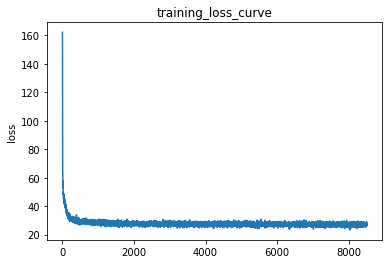

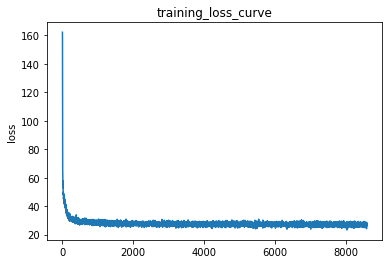

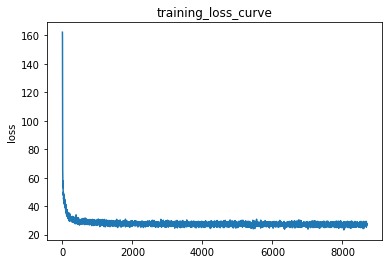

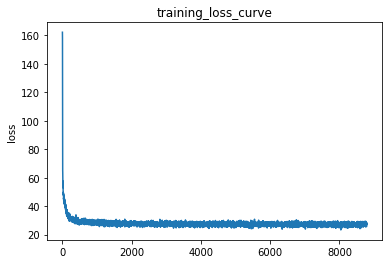

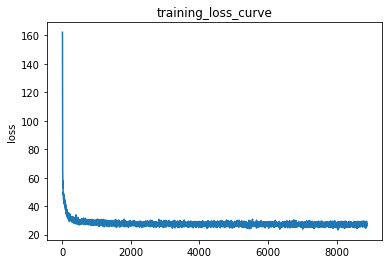

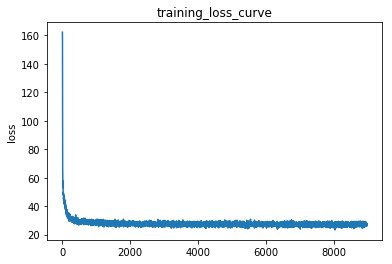

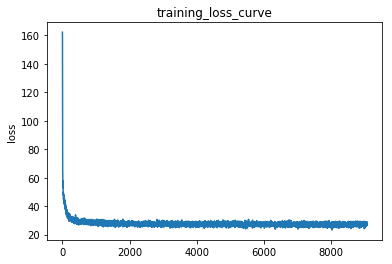

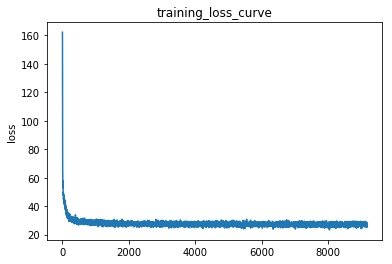

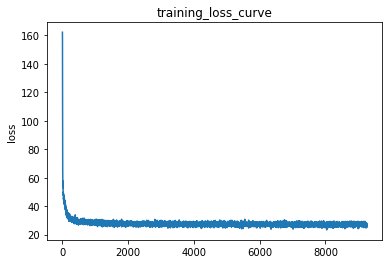

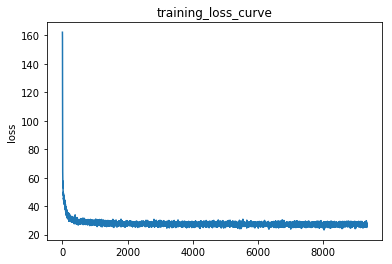

In [5]:
train_loss_list=[]

for epoch in range(1, args.epochs + 1):
    df = pd.DataFrame([], columns=["train_loss"])
    train_loss_list = train(epoch, train_loss_list)

    df['train_loss'] = train_loss_list
    df.to_csv('results/CVAE.csv', index=False)

    fig = plt.figure()
    plt.plot(train_loss_list)
    plt.title('training_loss_curve')
    plt.ylabel('loss')
    fig.savefig('results/training_loss.png') 
    
    
    train(epoch, train_loss_list)
    test(epoch)
    with torch.no_grad():
        c = []
        for i in range(0, 10): 
            c.append((range(0, 10)))
        c = Variable(torch.tensor(c))
        c = c.view(-1, 1)
        sample = torch.randn(100, 20).to(device)
        sample = sample.cuda()
        sample = model.decode(sample, c).cpu()
        save_image(sample.view(100, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png', nrow=10)
